In [ ]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

current_dir = '/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainCorr'
print(current_dir)
if current_dir not in sys.path:
    sys.path.append(current_dir)

!pip install torcheval
!pip install opencv-python

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torcheval.metrics import MulticlassF1Score, MulticlassAUROC, MulticlassConfusionMatrix

import MHFN_batch
from MHFN_batch import MHFN_layer

from collections import defaultdict

import cv2
from cv2 import GaussianBlur

/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainCorr
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
# fixing seeds for deterministic behaviour
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
n_per_class = 10
transform = transforms.ToTensor()

full_training = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

class_counts = defaultdict(int)
selected_indices = []

for idx, (img, label) in enumerate(full_training):
    if class_counts[label] < n_per_class:
        selected_indices.append(idx)
        class_counts[label] += 1
        #print(class_counts)
    if all(c >= n_per_class for c in class_counts.values()):
        break

training_data = Subset(full_training, selected_indices)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.23MB/s]


100


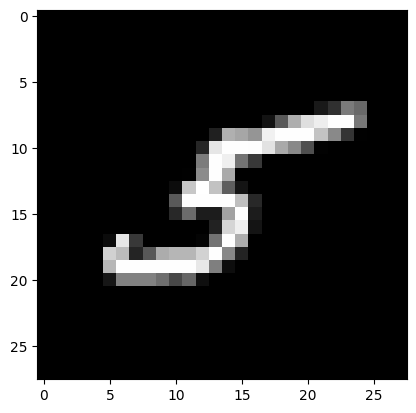

In [ ]:
print(len(training_data))
plt.imshow(training_data[99][0][0], cmap='gray')

In [ ]:
class AddCorrelatedNoise(object):
    def __init__(self, mean=0., std=0.1, blur_kernel=(5,5)):
        self.mean = mean
        self.std = std
        self.blur_kernel = blur_kernel
    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean

        blurred = []
        for channel in noisy:
            ch_np = channel.detach().cpu().numpy().astype(np.float32)
            ch_blur = cv2.GaussianBlur(ch_np, self.blur_kernel, 0)
            tens = torch.from_numpy(ch_blur)
            blurred.append(tens)
            result = torch.stack(blurred).float()
            result = (result-result.min())/(result.max()-result.min()+1e-6)

        return result

transform = transforms.Compose([
    transforms.ToTensor(),
    AddCorrelatedNoise(0., 0.1, (5,5))
])

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
    )

In [ ]:
train_loader = DataLoader(training_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

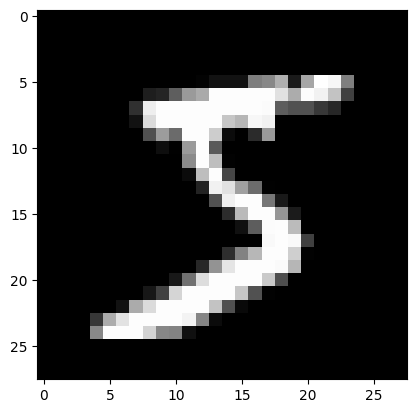

In [ ]:
plt.imshow(training_data[0][0][0], cmap='gray')

In [ ]:
plt.imshow(test_data[0][0][0], cmap='gray')

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.feature_extractor = torch.nn.Sequential(
            self.make_block(1, 16),
            self.make_block(16, 32),
            self.make_block(32, 64),
            self.make_block(64, 128),
            self.make_block(128, 256),
            self.make_block(256, 256)
            # torch.nn.AvgPool2d(5),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(256, 10),
            #torch.nn.Softmax() torch.nn.CrossEntropyLoss already does that
        )

    def make_block(self, in_channels, out_channels):
        block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        # torch.nn.BatchNorm2d(out_channels),
        # torch.nn.ReLU(),
        # torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.Dropout(0.1),
        torch.nn.ReLU()
        )
        return block

    def forward(self, x):
        features = self.feature_extractor(x)
        probs = self.classifier(features)
        return probs

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classifier = Classifier()

##### Check if input is correct (size, noise)

In [ ]:
print('Device:', device)
classifier.to(device)

loss_fun = torch.nn.CrossEntropyLoss()
loss_fun.to(device)
LR = 0.001
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=1e-4)

f1_metric = MulticlassF1Score(num_classes=10)
conf_metric = MulticlassConfusionMatrix(num_classes=10, normalize='all')
auc_metric = MulticlassAUROC(num_classes=10, average=None)

epochs = 250
step = 0

classifier.train()

for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # plt.imshow(images[1][0].cpu(), cmap='gray')
        # break
        optimizer.zero_grad()
        probs = classifier(images)
        loss = loss_fun(probs.squeeze(1), labels)
        # print(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()
        step += 1
        if step % 50 == 0:
            preds = torch.argmax(probs, dim=1)
            acc = (preds.squeeze() == labels).float().mean()
            f1_metric.update(preds, labels)
            conf_metric.update(preds, labels)
            auc_metric.update(probs, labels)
            f1 = f1_metric.compute()
            conf = conf_metric.compute()
            auc = auc_metric.compute()

            print(f"{step}[{epoch}]: loss {loss.item()} acc:{100*acc:.1f}")
            print(f"f1:{f1}")
            print(f"conf:{conf}")
            print(f"auc:{auc}")


data = {"step": step,
        "classifier": classifier.state_dict(),
        "optimizer": optimizer.state_dict()}

Device: cuda
50[4]: loss 1.6698967218399048 acc:40.0
f1:0.40000003576278687
conf:tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1000, 0.1000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/MHFN/FewTrain/FewTrainCorr/"

In [ ]:
torch.save(data, PROJECT_DIR + 'classifier_corr_simple.pth')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
#raise Exception('Halt! We are visualizing!')
data = torch.load(PROJECT_DIR + 'classifier_corr_simple.pth', map_location=torch.device(device))
classifier = Classifier()
classifier.load_state_dict(data['classifier'])
classifier.to(device)

Device: cuda


Classifier(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
num_runs = 5
accs = []
f1s = []
confs = []
aucs = []

for run in range(num_runs):
    correct = 0
    total = 0
    f1_metric = MulticlassF1Score(num_classes=10)
    conf_metric = MulticlassConfusionMatrix(num_classes=10, normalize='true')
    auc_metric = MulticlassAUROC(num_classes=10, average=None)

    classifier.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # print(max(images[1][0].flatten()))
            # plt.imshow(images[1][0].cpu(), cmap='gray')
            # break

            probs = classifier(images)
            preds = torch.argmax(probs, dim=1)
            correct += (preds == labels).float().sum().item()
            total += len(labels)

            f1_metric.update(preds, labels)
            conf_metric.update(preds, labels)
            auc_metric.update(probs, labels)

    acc = correct / total
    accs.append(acc*100)
    f1s.append(f1_metric.compute().item())
    confs.append(conf_metric.compute())
    aucs.append(auc_metric.compute())

# Average performance:
print(f"Avg Accuracy: {torch.tensor(accs).mean():.2f}")
print(f"Avg F1: {torch.tensor(f1s).mean():.4f}")
print(f"Avg Confusion Matrix (last run shown):\n{confs[-1]}")
print(f"Avg AUC (per class):\n{torch.stack(aucs).mean(dim=0)}")

Avg Accuracy: 28.47
Avg F1: 0.2847
Avg Confusion Matrix (last run shown):
tensor([[8.8061e-01, 0.0000e+00, 3.6735e-02, 6.8367e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.4286e-02, 0.0000e+00],
        [7.6300e-01, 0.0000e+00, 8.8106e-04, 8.0176e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.5595e-01, 0.0000e+00],
        [4.4574e-02, 0.0000e+00, 2.3256e-01, 6.9186e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 3.1008e-02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9901e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 9.9010e-04, 0.0000e+00],
        [4.0020e-01, 0.0000e+00, 3.0550e-03, 4.9491e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0183e-01, 0.0000e+00],
        [2.5785e-02, 0.0000e+00, 1.4574e-02, 9.3946e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.0179e-02, 0.0000e+00],
        [6.2109e-01, 0.0000e+00, 9.9165e-02, 1.2109e-01, 0.0000e+00, 0.0000e+00,
         0.

In [ ]:
print(accs)

[28.4, 28.53, 28.660000000000004, 28.610000000000003, 28.17]
